<a href="https://colab.research.google.com/github/CoweiChou/Cats_CNNmodel/blob/main/01_resnet50_base_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic module
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # progress bar
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torchvision #針對影像
from torchvision import transforms # 資料前處理
import torchsummary
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [ ]:
# print version of PyTorch
torch.__version__, torchvision.__version__

('2.0.1+cu118', '0.15.2+cu118')

執行階段 -> 變更執行階段類型

In [ ]:
# 檢查GPU使用內容
# !nvidia-smi

In [ ]:
MODEL_PATH = 'model.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


## Download Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/train

/content/drive/MyDrive/train


In [ ]:
from glob import glob
# search .bmp file paths
paths = glob("/content/drive/MyDrive/train/*_*.jpg")
print("number of samples", len(paths))

number of samples 2115


In [ ]:
# Define Parameters 定義超參數
IMG_SIZE = 200 # 128
# 種類
# NUM_CLASS = 7
# Class name and class mapping
# 類別名稱
# class_names = ['黑', '白', '橘', '黑白', '三花', '虎斑','玳瑁']
class_names = ['black', 'white', 'orange', 'tuxedo', 'calico', 'tabby','tortoiseshell']

class_map = {cls: i for i, cls in enumerate(class_names)}
print(class_map)
NUM_CLASS = len(class_names)

{'black': 0, 'white': 1, 'orange': 2, 'tuxedo': 3, 'calico': 4, 'tabby': 5, 'tortoiseshell': 6}


## Dataset & Dataloader

In [ ]:
class CatsDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, img_size, cls_map, transform):
        self.img_paths = img_paths
        self.img_size = img_size
        self.cls_map = cls_map
        self.transform = transform

    def __len__(self):
        """number of samples"""
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Read img
        path = self.img_paths[idx] # get img path
        img = Image.open(path).convert('RGB')

        # transform img
        img = self.transform(img)

        # Read class index
        cls_name = path.split('/')[-1].split('_')[0]
        cls_idx = self.cls_map[cls_name]
        cls_idx = torch.tensor(cls_idx, dtype=torch.int64)
        return img, cls_idx

In [ ]:
# split dataset
train_paths, val_paths = train_test_split(paths,
    random_state=556,
    test_size=0.2)

len(train_paths), len(val_paths)

(1692, 423)

In [ ]:
preprocess = transforms.Compose([
    transforms.ToTensor(), # Convert to Tensor
    # ...
])

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

# Preprocess Transform
# transform =  ResNet50_Weights.DEFAULT.transforms()
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 将图像调整为相同的尺寸
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Build Dataset
train_ds = CatsDataset(train_paths, IMG_SIZE, class_map,
                      transform)
val_ds = CatsDataset(val_paths, IMG_SIZE, class_map,
                    transform)

In [ ]:
# Check your dataset
print('Number of training   samples:', len(train_ds))
print('Number of validation samples:', len(val_ds))

Number of training   samples: 1692
Number of validation samples: 423


In [ ]:
transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

## Data Proprocess 資料前處理



#### Combine Dataset with DataLoader
一筆一筆資料變成批次

**torch.utils.data.DataLoader**: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

* form a **batch**
* data sampler
* reading order (shuffle) 順序打亂

In [ ]:
# Build dataloader
BATCH_SIZE = 32 # BATCH_SIZE
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, BATCH_SIZE)

In [ ]:
# Use DataLoader to generate minibatches
# BATCH_SIZE = 256
# train_dataloader = torch.utils.data.DataLoader(
#     train_ds,
#     batch_size=BATCH_SIZE,
#     shuffle=True)
# val_dataloader = torch.utils.data.DataLoader(
#     val_ds,
#     batch_size=BATCH_SIZE)

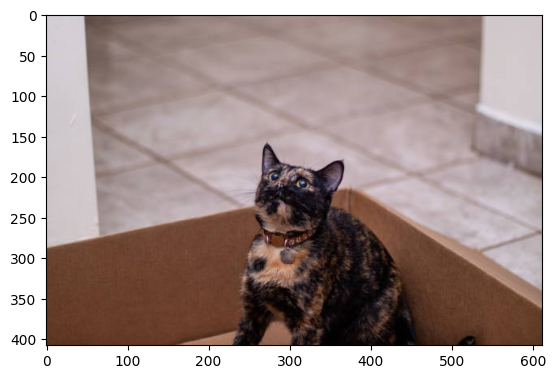

(408, 612, 3)


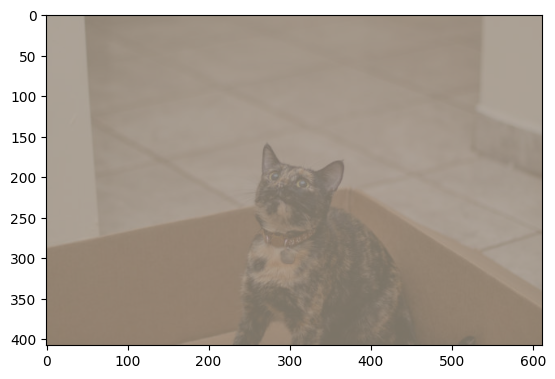

Class: tensor(6)


In [ ]:
# 圖像在不同的前處理和還原步驟後的效果
# Visulize sample
idx = np.random.randint(0, len(train_ds))
img, cls = train_ds[idx]

img_normalized = img.permute(1, 2, 0)
plt.imshow(img_normalized)
plt.show()

# Convert back to original value
img_raw = img.numpy().transpose(1, 2, 0) # (3, 256, 256) -> (256, 256, 3)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_raw = std * img_raw + mean
img_raw = np.clip(img_raw, 0, 1)
print(img_raw.shape)
plt.imshow(img_raw)
plt.show()

print('Class:', cls)

#### Build Model

In [ ]:
model = torchvision.models.resnet50()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# replace classifier
num_features = model.fc.in_features # len of feature vectors

# # Freeze model
# for param in model.parameters():
#     param.requires_grad = False

# Replace classifier
model.fc = nn.Linear(num_features, 7)
print(model.fc)


Linear(in_features=2048, out_features=7, bias=True)


In [ ]:

summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

#### Training: Optimizing the Model Parameters

In [ ]:
loss_fn = nn.CrossEntropyLoss() # Softmax + negative log likelihood loss (nn.NLLLoss)
optimizer = torch.optim.SGD(
    params=model.parameters(), # parameters to optimize 更新參數
    lr=1e-2, # learning rate: 1e-4, 1e-2... 學習率
)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to device 資料丟到gpu上

        # zero the parameter gradients 歸零optimizer
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x) # 計算預測值
        loss = loss_fn(pred, y) # 計算誤差

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients 拿誤差計算梯度
        optimizer.step() # update model params 讓optimizer來更新

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn): # 測試不需optimizer
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data 不需要梯度，算起來比較快
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [ ]:
# EPOCHS = 50
# logs = {
#     'train_loss': [], 'train_acc': [],
#     'val_loss': [], 'val_acc': []
# }
# for epoch in tqdm(range(EPOCHS)):
#     train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
#     val_loss, val_acc = test(val_loader, model, loss_fn)

#     print(f'EPOCH: {epoch} \
#     train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
#     val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

#     logs['train_loss'].append(train_loss)
#     logs['train_acc'].append(train_acc)
#     logs['val_loss'].append(val_loss)
#     logs['val_acc'].append(val_acc)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0     train_loss: 3.1941, train_acc: 0.155     val_loss: 3.1347, val_acc: 0.151 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 1     train_loss: 2.4528, train_acc: 0.179     val_loss: 3.7459, val_acc: 0.194 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 2     train_loss: 2.2791, train_acc: 0.212     val_loss: 2.6960, val_acc: 0.206 


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0000     train_loss: 2.0680, train_acc: 0.239     val_loss: 2.3455, val_acc: 0.213 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0001     train_loss: 1.9366, train_acc: 0.268     val_loss: 2.9665, val_acc: 0.199 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0002     train_loss: 1.9321, train_acc: 0.280     val_loss: 1.8876, val_acc: 0.293 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0003     train_loss: 1.8597, train_acc: 0.311     val_loss: 2.1504, val_acc: 0.381 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0004     train_loss: 1.6979, train_acc: 0.355     val_loss: 1.8749, val_acc: 0.329 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0005     train_loss: 1.6633, train_acc: 0.351     val_loss: 1.9306, val_acc: 0.345 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0006     train_loss: 1.6608, train_acc: 0.371     val_loss: 2.4512, val_acc: 0.310 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0007     train_loss: 1.6604, train_acc: 0.393     val_loss: 1.5890, val_acc: 0.404 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0008     train_loss: 1.5217, train_acc: 0.431     val_loss: 1.7349, val_acc: 0.463 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0009     train_loss: 1.4447, train_acc: 0.482     val_loss: 1.4238, val_acc: 0.459 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0010     train_loss: 1.3457, train_acc: 0.502     val_loss: 1.3486, val_acc: 0.473 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0011     train_loss: 1.3178, train_acc: 0.527     val_loss: 1.7889, val_acc: 0.433 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0012     train_loss: 1.2304, train_acc: 0.546     val_loss: 1.3882, val_acc: 0.511 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0013     train_loss: 1.1363, train_acc: 0.590     val_loss: 1.3487, val_acc: 0.565 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0014     train_loss: 1.1564, train_acc: 0.567     val_loss: 1.2514, val_acc: 0.582 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0015     train_loss: 1.1065, train_acc: 0.598     val_loss: 1.2273, val_acc: 0.572 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0016     train_loss: 1.0452, train_acc: 0.626     val_loss: 1.2462, val_acc: 0.589 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0017     train_loss: 0.9740, train_acc: 0.653     val_loss: 1.1333, val_acc: 0.636 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0018     train_loss: 0.9051, train_acc: 0.673     val_loss: 1.1286, val_acc: 0.598 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0019     train_loss: 0.8481, train_acc: 0.693     val_loss: 1.0938, val_acc: 0.626 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0020     train_loss: 0.8421, train_acc: 0.699     val_loss: 1.3078, val_acc: 0.636 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0021     train_loss: 0.7342, train_acc: 0.730     val_loss: 1.4440, val_acc: 0.603 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0022     train_loss: 0.7515, train_acc: 0.733     val_loss: 1.0794, val_acc: 0.610 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0023     train_loss: 0.6842, train_acc: 0.755     val_loss: 1.9556, val_acc: 0.560 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0024     train_loss: 0.6217, train_acc: 0.778     val_loss: 1.2804, val_acc: 0.603 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0025     train_loss: 0.6556, train_acc: 0.761     val_loss: 1.0316, val_acc: 0.674 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0026     train_loss: 0.6111, train_acc: 0.784     val_loss: 1.8792, val_acc: 0.537 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0027     train_loss: 0.5486, train_acc: 0.803     val_loss: 1.1069, val_acc: 0.648 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0028     train_loss: 0.5210, train_acc: 0.819     val_loss: 1.5925, val_acc: 0.626 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0029     train_loss: 0.4480, train_acc: 0.837     val_loss: 1.4137, val_acc: 0.600 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0030     train_loss: 0.4437, train_acc: 0.852     val_loss: 1.4403, val_acc: 0.577 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0031     train_loss: 0.3730, train_acc: 0.866     val_loss: 1.3843, val_acc: 0.641 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0032     train_loss: 0.3833, train_acc: 0.865     val_loss: 1.1370, val_acc: 0.660 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0033     train_loss: 0.3443, train_acc: 0.876     val_loss: 1.2826, val_acc: 0.657 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0034     train_loss: 0.2854, train_acc: 0.906     val_loss: 4.2883, val_acc: 0.468 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0035     train_loss: 0.3168, train_acc: 0.895     val_loss: 1.0841, val_acc: 0.671 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0036     train_loss: 0.2924, train_acc: 0.901     val_loss: 1.8196, val_acc: 0.660 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0037     train_loss: 0.2934, train_acc: 0.901     val_loss: 1.1208, val_acc: 0.645 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0038     train_loss: 0.1979, train_acc: 0.928     val_loss: 1.8319, val_acc: 0.501 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0039     train_loss: 0.2394, train_acc: 0.920     val_loss: 1.1587, val_acc: 0.671 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0040     train_loss: 0.1750, train_acc: 0.938     val_loss: 1.7135, val_acc: 0.652 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0041     train_loss: 0.1761, train_acc: 0.947     val_loss: 1.1859, val_acc: 0.702 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0042     train_loss: 0.1667, train_acc: 0.947     val_loss: 1.1850, val_acc: 0.686 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0043     train_loss: 0.1871, train_acc: 0.930     val_loss: 1.6437, val_acc: 0.579 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0044     train_loss: 0.1932, train_acc: 0.936     val_loss: 1.9976, val_acc: 0.660 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0045     train_loss: 0.1254, train_acc: 0.954     val_loss: 1.0423, val_acc: 0.697 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0046     train_loss: 0.1195, train_acc: 0.965     val_loss: 1.1176, val_acc: 0.723 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0047     train_loss: 0.1032, train_acc: 0.966     val_loss: 1.1899, val_acc: 0.671 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0048     train_loss: 0.1669, train_acc: 0.939     val_loss: 1.3365, val_acc: 0.697 


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

EPOCH: 0049     train_loss: 0.0891, train_acc: 0.974     val_loss: 1.0602, val_acc: 0.712 


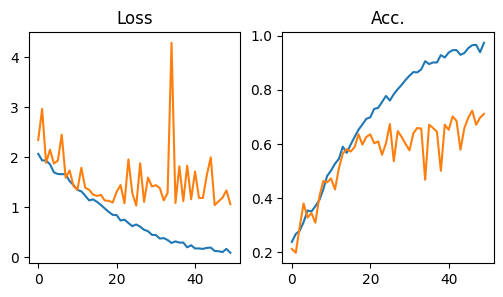

In [ ]:
EPOCHS = 50
logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch:04d} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

# plot result
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(logs['train_loss'])
plt.plot(logs['val_loss'])
plt.subplot(1, 2, 2)
plt.title('Acc.')
plt.plot(logs['train_acc'])
plt.plot(logs['val_acc'])
plt.show()

#### Logs

In [ ]:
# # Plot loss curve
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title('Loss')
# plt.plot(logs['train_loss'])
# plt.plot(logs['val_loss'])
# plt.legend(['train_loss', 'val_loss'])
# # plot acc
# plt.subplot(1, 2, 2)
# plt.title('Accuracy')
# plt.plot(logs['train_acc'])
# plt.plot(logs['val_acc'])
# plt.legend(['train_acc', 'val_acc'])
# plt.show()

Final Test Accuracy: 0.0000


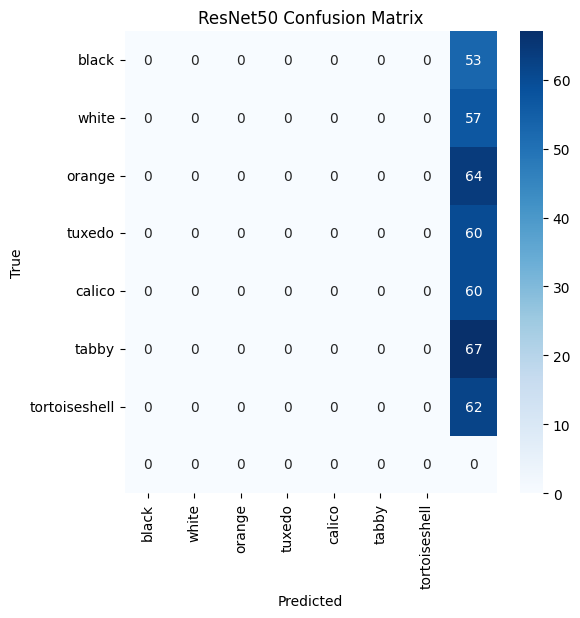

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# ...（之前的代码）

# Calculate final accuracy on test set
final_test_preds = []
final_test_labels = []

model.eval()  # Set model to evaluation mode

# Collect predictions and true labels for test set
with torch.no_grad():
    for x_test, y_test in val_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        outputs = model(x_test)
        _, preds = torch.max(outputs, 1)
        final_test_preds.extend(preds.cpu().numpy())
        final_test_labels.extend(y_test.cpu().numpy())

# Calculate accuracy on test set
test_accuracy = accuracy_score(final_test_labels, final_test_preds)

# Display accuracy
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Create confusion matrix for test set
test_confusion = confusion_matrix(final_test_labels, final_test_preds)

# Plot confusion matrix for test set
plt.figure(figsize=(6, 6))
sns.heatmap(test_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("ResNet50 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# Calculate misclassified indices
misclassified_indices = []
with torch.no_grad():
    for i, (x_test, y_test) in enumerate(val_loader):
        x_test, y_test = x_test.to(device), y_test.to(device)
        outputs = model(x_test)
        _, preds = torch.max(outputs, 1)

        # Check if prediction is incorrect
        for j in range(len(preds)):
            if preds[j] != y_test[j]:
                misclassified_indices.append(i * val_loader.batch_size + j)

# Choose 10 misclassified samples to display
num_samples_to_display = 10
for i in misclassified_indices[:num_samples_to_display]:
    example_image = val_ds[i][0]
    example_label = val_ds[i][1]

    # Generate CAM heatmap for the example image
    cam_heatmap = generate_cam(model, example_image.unsqueeze(0).to(device), example_label.item())

    # Resize the CAM heatmap to match the image size
    cam_heatmap_resized = torch.nn.functional.interpolate(cam_heatmap.unsqueeze(0), size=example_image.shape[-2:], mode='bilinear', align_corners=False).squeeze(0)

    # Apply colormap to the heatmap
    colormap = plt.get_cmap('jet')
    colored_heatmap = colormap(cam_heatmap_resized.cpu().numpy())

    # Display the original image, true label, and predicted label
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(transforms.ToPILImage()(example_image.cpu()))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(colored_heatmap)
    plt.title('CAM Heatmap')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(transforms.ToPILImage()(example_image.cpu()))
    plt.imshow(colored_heatmap, alpha=0.5)
    plt.title(f'True Label: {class_names[example_label.item()]}\nPredicted Label: {class_names[preds[i % val_loader.batch_size].item()]}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


AttributeError: ignored

#### Save Model

Saving & Loading Model (weights only)

**Recommended**

In [ ]:
# model parameters
model.state_dict()

In [ ]:
# 建議用這個方式來存檔和讀檔 比較沒有版本問題
PATH = './model_weights.pth' #.pth or .pt
# save weights
torch.save(model.state_dict(), PATH)

# load weights
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Saving & Loading Model (entire model)

In [ ]:
MODEL_PATH = './model.pth'
# save model
torch.save(model, MODEL_PATH)
# load model
model = torch.load(MODEL_PATH)

#### Evaluation

In [ ]:
# load model
model = torchvision.models.resnet50()

PATH = "/content/MyDrive/AI project/模型訓練/base-model.pth"
model.load_state_dict(torch.load(PATH))
model.eval()

FileNotFoundError: ignored

In [ ]:
# take first 2 images
n = 2
for (images, labels) in val_dataloader:
    images, labels = images[:n], labels[:n]
    images_grid = torchvision.utils.make_grid(images[:n])
    images_grid = images_grid.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
    plt.imshow(images_grid.numpy())
    break

In [ ]:
# take first 2 images
n = 2
for (images, labels) in val_dataloader:
    images, labels = images[:n], labels[:n]
    break

# Predict by model
with torch.no_grad(): # 不需梯度計算
    pred = model(images) # predict logits
print('raw_prediction logtis', pred, pred.shape, sep="\n") # 顯示原始logtis

NameError: ignored

In [ ]:
pred_softmax = nn.Softmax(dim=1)(pred) # probabilities
print('prediction after softmax', pred_softmax, pred_softmax.shape, sep="\n") # softmax轉換logtis

In [ ]:
# max_prob: max probability of each samples
# predicted_cls: the index of max prob
max_prob, predicted_cls = torch.max(pred_softmax, dim=1)

In [ ]:
predicted_cls = pred_softmax.argmax(dim=1) # argmax計算最大值

In [ ]:
predicted_cls

In [ ]:
pred_softmax.argmax(dim=1)

In [ ]:
print('GroundTruth: ', ' '.join(class_names[labels[j]] for j in range(n)))
print('Prediction: ', ' '.join(class_names[predicted_cls[j]] for j in range(n)))